# Compute PCA on syllables, correlate PC2 with velocity

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from toolz import frequencies, sliding_window
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import format_plots, PlotConfig, save_factory, figure

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "age-manifold", tight_layout=False)

In [3]:
def compute_tm(df, flat=True):
    rle = df.query('onsets')['relabeled_syllables']
    counts = frequencies(sliding_window(2, rle))
    tm = np.zeros((rle.max() + 1,) * 2)
    for k, v in counts.items():
        tm[k] = v
    if flat:
        s = pd.Series(tm[~np.eye(tm.shape[0], dtype=bool)].flatten() / np.sum(tm)).rename('freq')
        s.index.name = 'bigram'
        return s
    return tm / np.sum(tm)


def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

In [4]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df, usage_map = relabel_by_usage(df)
df['age'] = df['age'].map(age_map)

usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)

tms = df.query('onsets').groupby(['age', 'uuid'], sort=False).apply(compute_tm).reset_index()
tm_mtx = tms.pivot_table(values='freq', columns='bigram', index=['age', 'uuid']).fillna(0)

In [5]:
speed = df.groupby(['age', 'uuid'], sort=False)['velocity_3d_mm'].mean()

In [6]:
pca = PCA(n_components=15)
# pcs = pca.fit_transform(np.log(usage_mtx + 1e-6))
pcs = pca.fit_transform((usage_mtx + 1e-6))

In [7]:
pc_df = pd.DataFrame(pcs, index=usage_mtx.index, columns=[f'pc_{x:02d}' for x in range(pcs.shape[1])])

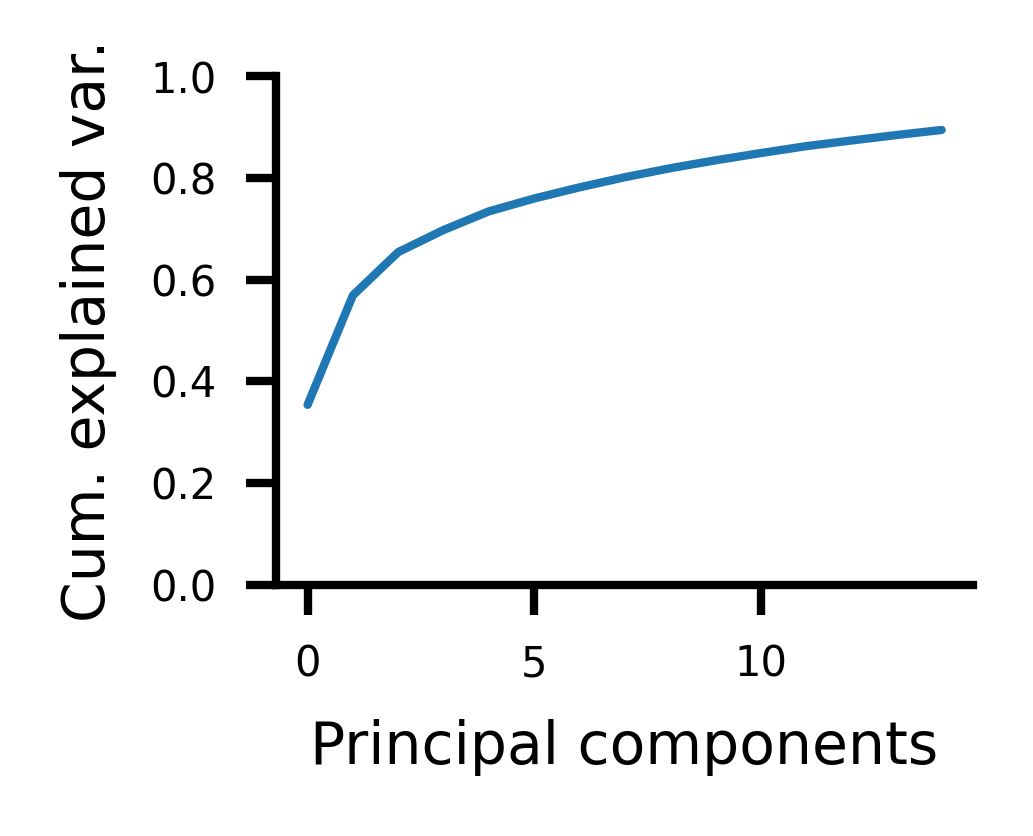

In [8]:
fig = figure(1.5, 1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
ax = fig.gca()
ax.set(xlabel="Principal components", ylabel="Cum. explained var.", ylim=(0, 1))
sns.despine()
saver(fig, 'pca-scree');

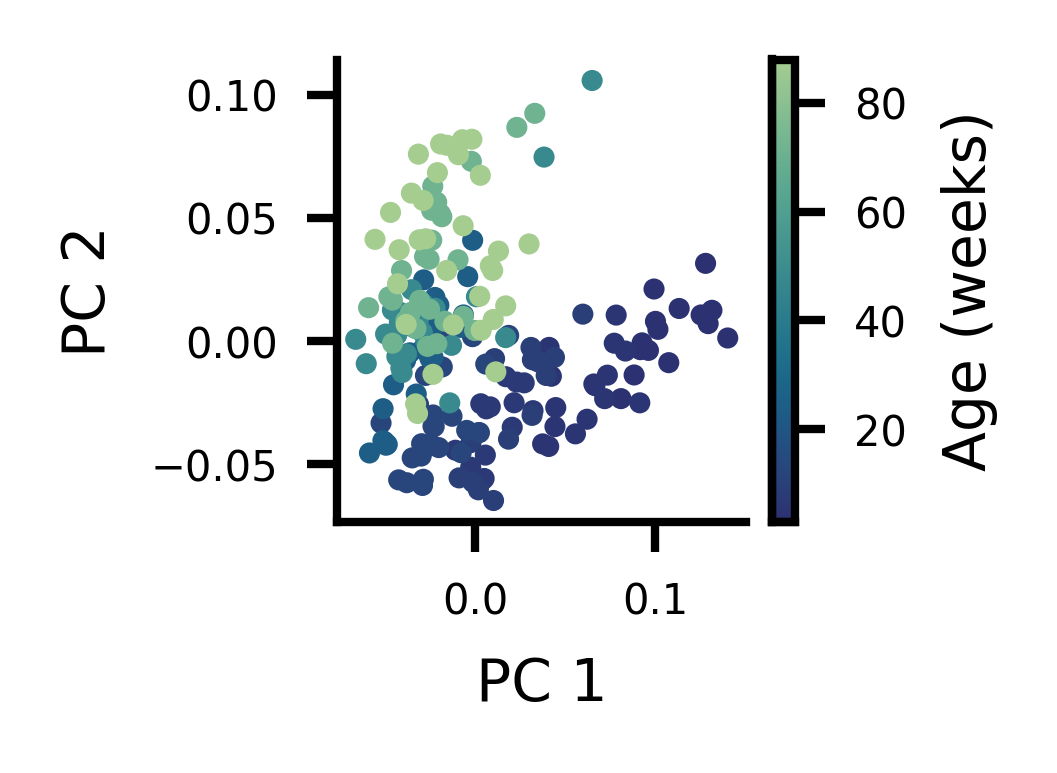

In [9]:
fig = figure(1.1, 1)
ax = fig.gca()
im = ax.scatter(*pcs[:, :2].T, c=usage_mtx.index.get_level_values(0), cmap='crest_r', s=3)
ax.set(xlabel='PC 1', ylabel='PC 2')
fig.colorbar(im, label='Age (weeks)')
sns.despine()
saver(fig, 'pc1-vs-pc2');

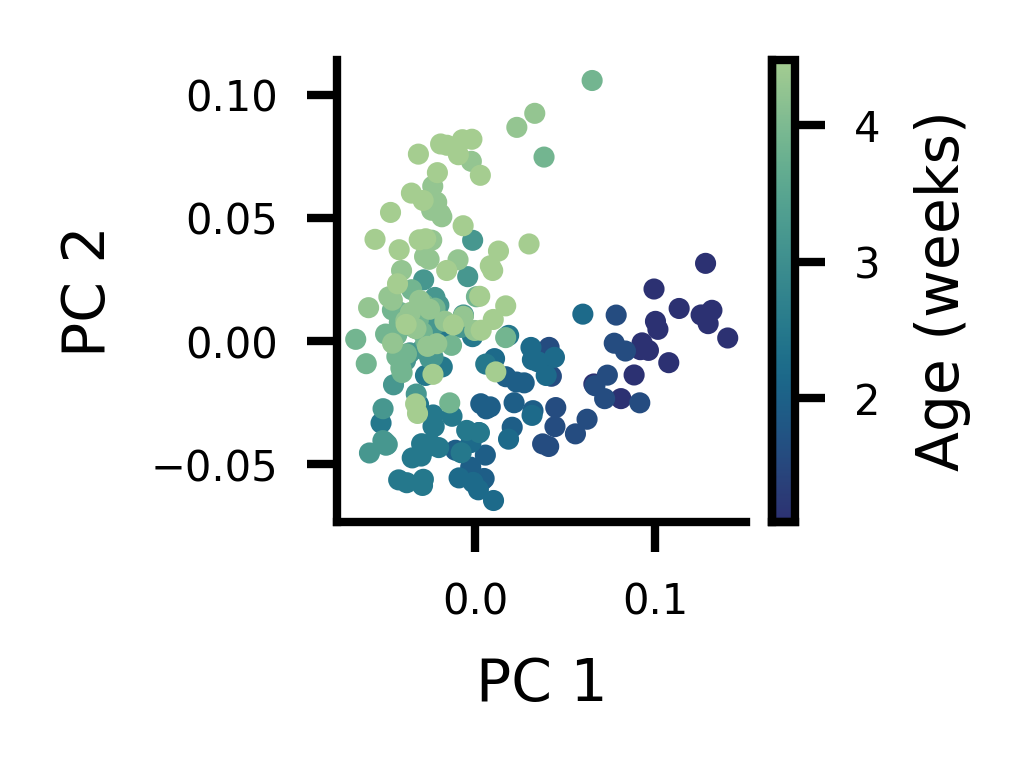

In [10]:
fig = figure(1.1, 1)
ax = fig.gca()
im = ax.scatter(*pcs[:, :2].T, c=np.log(usage_mtx.index.get_level_values(0)), cmap='crest_r', s=3)
ax.set(xlabel='PC 1', ylabel='PC 2')
fig.colorbar(im, label='Age (weeks)')
sns.despine()

In [11]:
combined = pc_df.join(speed)
filtered = combined.where(combined['velocity_3d_mm'] < 5)
filtered['velocity_3d_mm'] *= 30

In [12]:
corrs = filtered.corr(method='spearman')['velocity_3d_mm'].sort_values(ascending=False)
corrs

velocity_3d_mm    1.000000
pc_03             0.451233
pc_04             0.183172
pc_12             0.056686
pc_02             0.053643
pc_08             0.017148
pc_14            -0.018919
pc_10            -0.031333
pc_11            -0.034944
pc_06            -0.052885
pc_13            -0.076542
pc_07            -0.091188
pc_09            -0.105702
pc_00            -0.164012
pc_05            -0.274283
pc_01            -0.617700
Name: velocity_3d_mm, dtype: float64

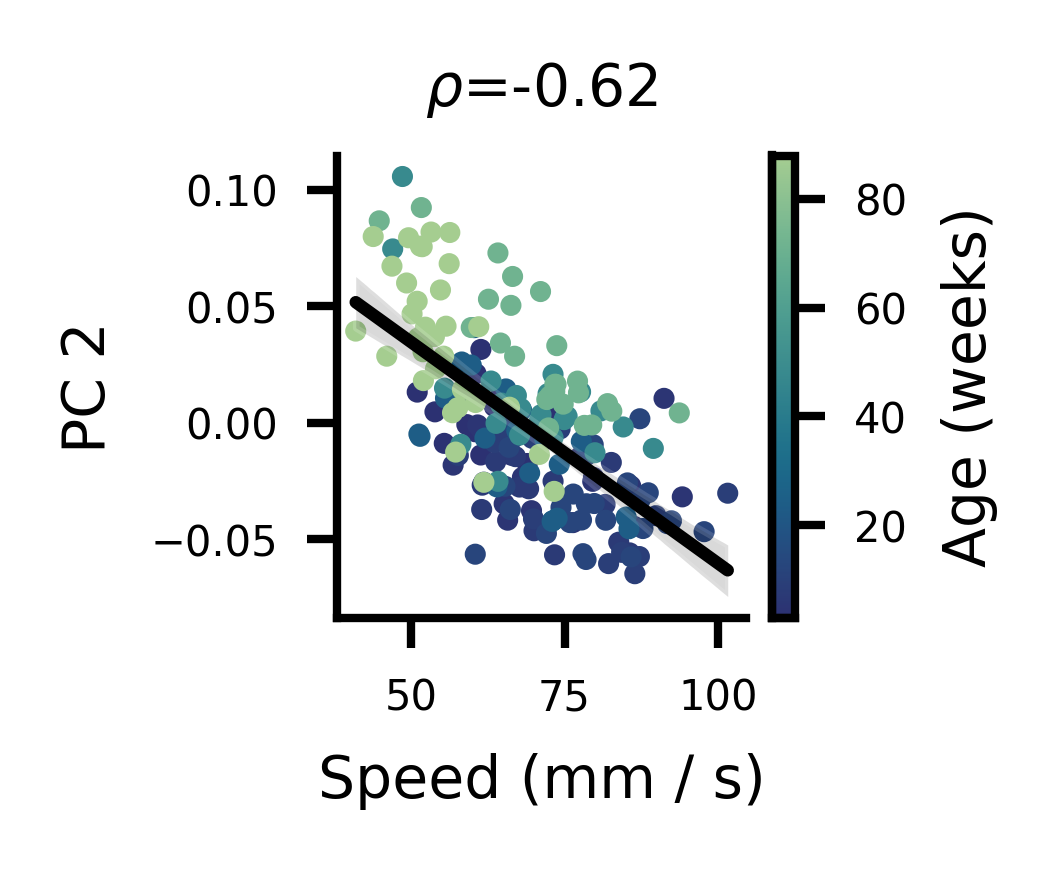

In [13]:
fig = figure(1.1, 1)
plt.scatter(filtered['velocity_3d_mm'], filtered['pc_01'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered, x='velocity_3d_mm', y='pc_01', scatter=False, color='k')
ax.set(xlabel='Speed (mm / s)', ylabel='PC 2')
plt.title(f'$\\rho$={corrs["pc_01"]:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc2-vs-speed');

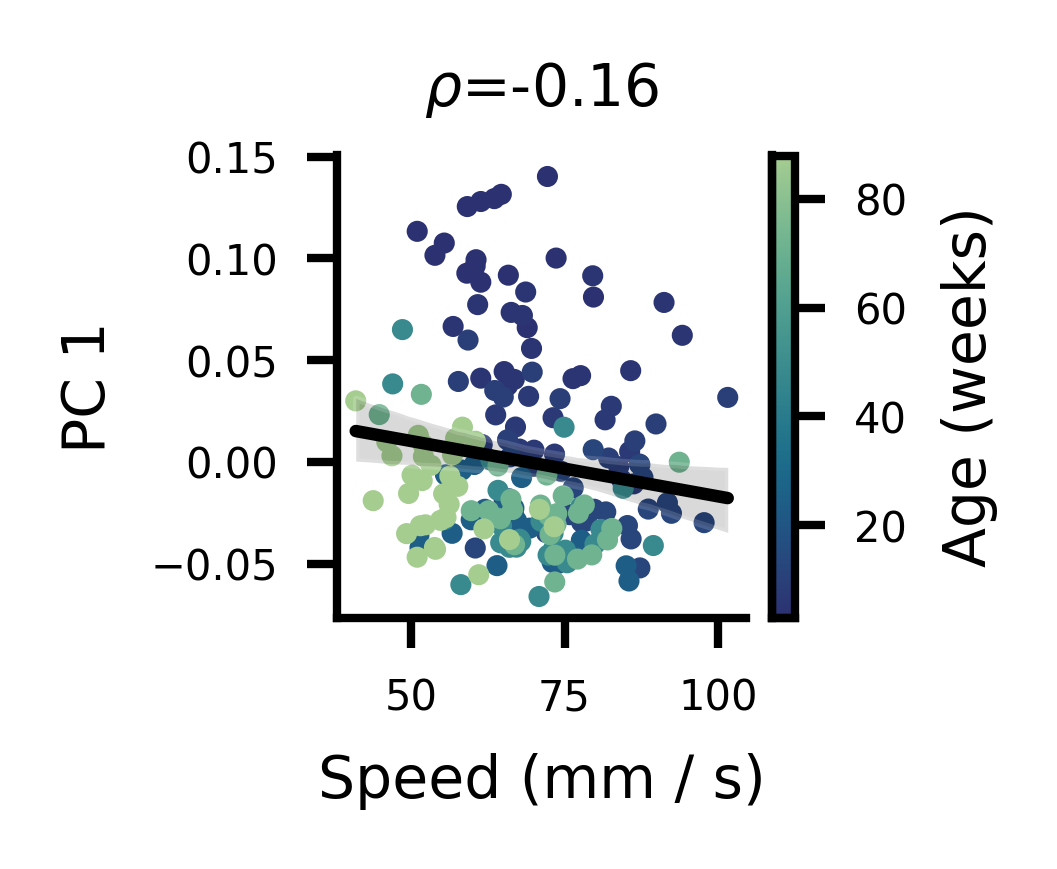

In [14]:
fig = figure(1.1, 1)
plt.scatter(filtered['velocity_3d_mm'], filtered['pc_00'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered, x='velocity_3d_mm', y='pc_00', scatter=False, color='k')
ax.set(xlabel='Speed (mm / s)', ylabel='PC 1')
plt.title(f'$\\rho$={corrs["pc_00"]:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc1-vs-speed');

In [15]:
c = filtered['pc_00'].corr(pd.Series(filtered.index.get_level_values(0), index=filtered.index), method='spearman')

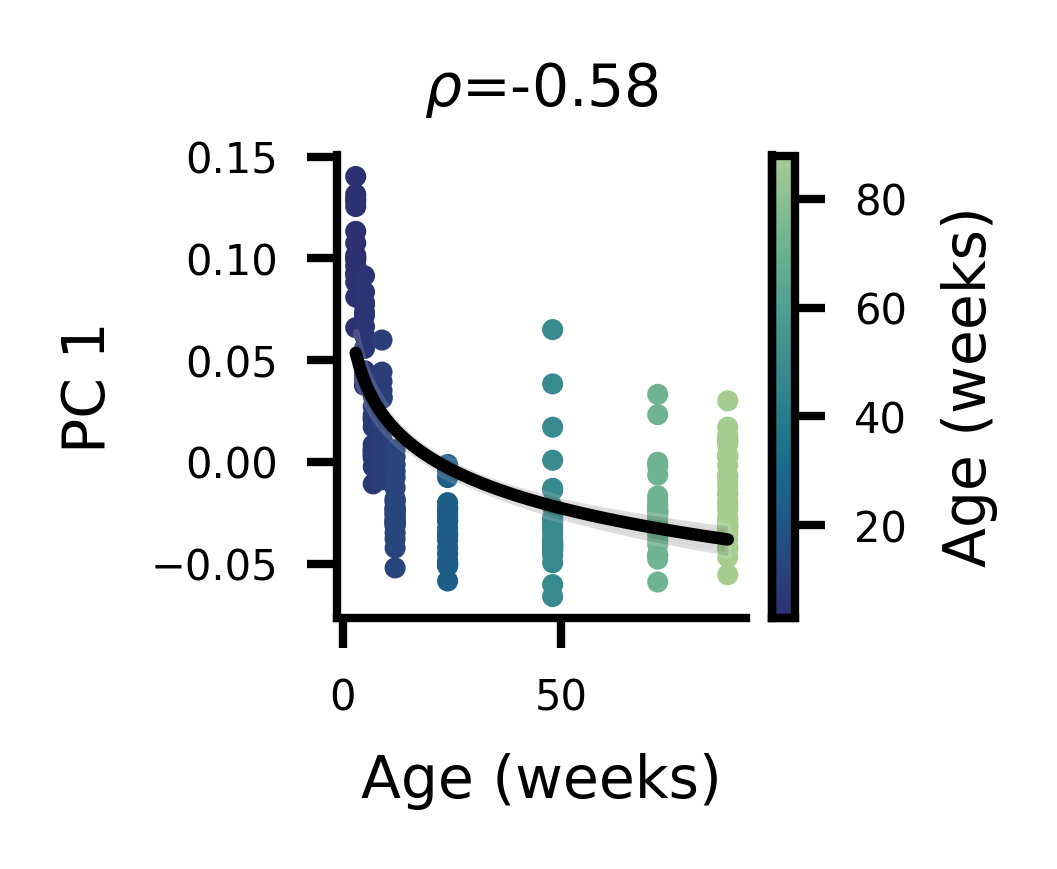

In [16]:
fig = figure(1.1, 1)
plt.scatter(filtered.index.get_level_values(0), filtered['pc_00'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered.reset_index(), x='age', y='pc_00', scatter=False, color='k', logx=True)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
plt.title(f'$\\rho$={c:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc1-vs-age');

In [17]:
age_c = filtered.corrwith(pd.Series(filtered.index.get_level_values(0), index=filtered.index), method='spearman')
age_c

pc_00            -0.576337
pc_01             0.596299
pc_02             0.247444
pc_03            -0.179835
pc_04            -0.078481
pc_05            -0.080172
pc_06             0.022847
pc_07             0.122945
pc_08             0.051247
pc_09            -0.065894
pc_10            -0.094892
pc_11            -0.083382
pc_12            -0.059374
pc_13            -0.033964
pc_14             0.075294
velocity_3d_mm   -0.312167
dtype: float64

In [18]:
age_c.abs().sort_values(ascending=False)

pc_01             0.596299
pc_00             0.576337
velocity_3d_mm    0.312167
pc_02             0.247444
pc_03             0.179835
pc_07             0.122945
pc_10             0.094892
pc_11             0.083382
pc_05             0.080172
pc_04             0.078481
pc_14             0.075294
pc_09             0.065894
pc_12             0.059374
pc_08             0.051247
pc_13             0.033964
pc_06             0.022847
dtype: float64

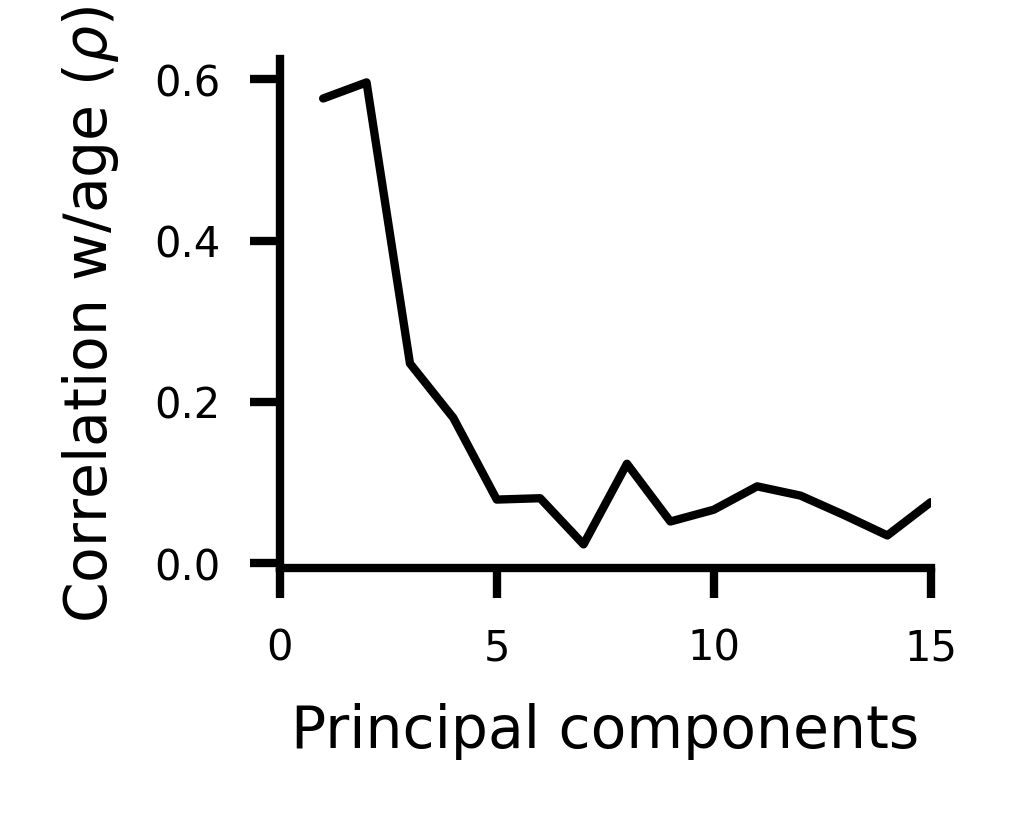

In [19]:
fig = figure(1.4, 1.1)
plt.plot(np.arange(1, 16), age_c.iloc[:-1].abs().to_numpy(), color='k')
ax = fig.gca()
ax.set(ylabel='Correlation w/age ($\\rho$)', xlabel='Principal components', xlim=(0, 15))
sns.despine()
saver(fig, 'pc-corr-vs-age');

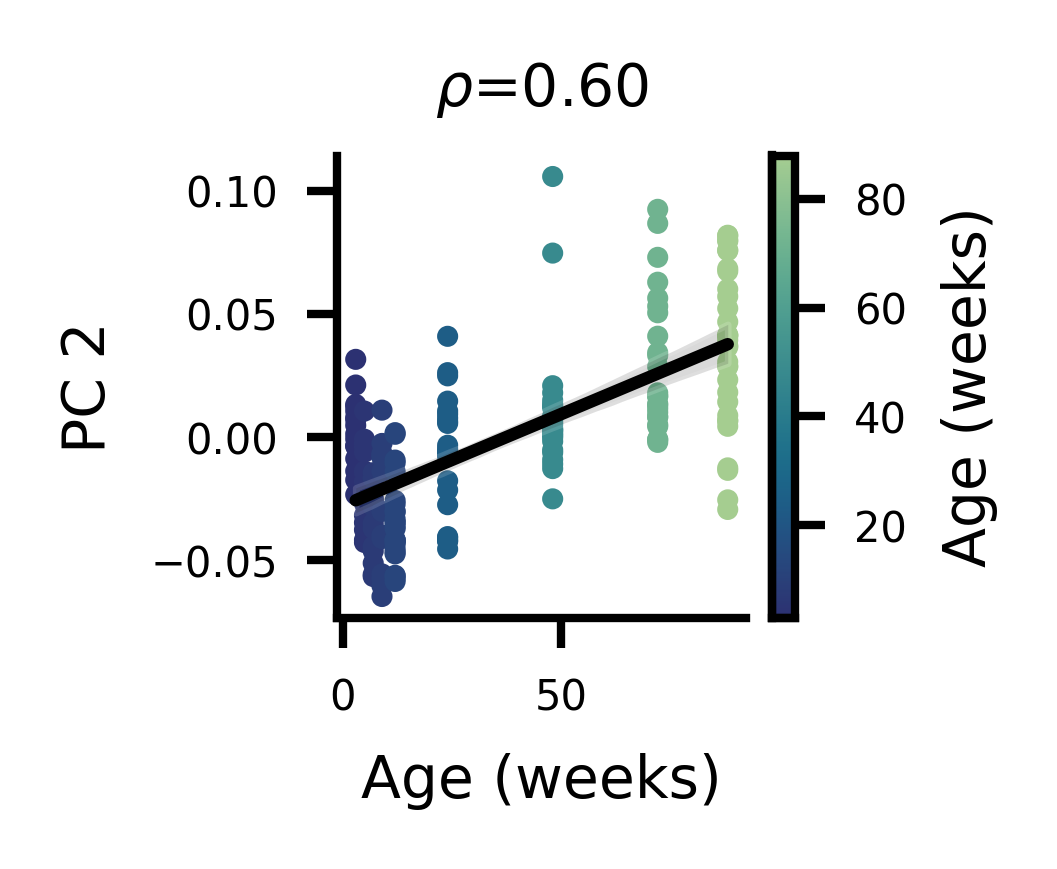

In [20]:
fig = figure(1.1, 1)
plt.scatter(filtered.index.get_level_values(0), filtered['pc_01'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered.reset_index(), x='age', y='pc_01', scatter=False, color='k', logx=False)
ax.set(xlabel='Age (weeks)', ylabel='PC 2')
plt.title(f'$\\rho$={age_c["pc_01"]:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc2-vs-age');

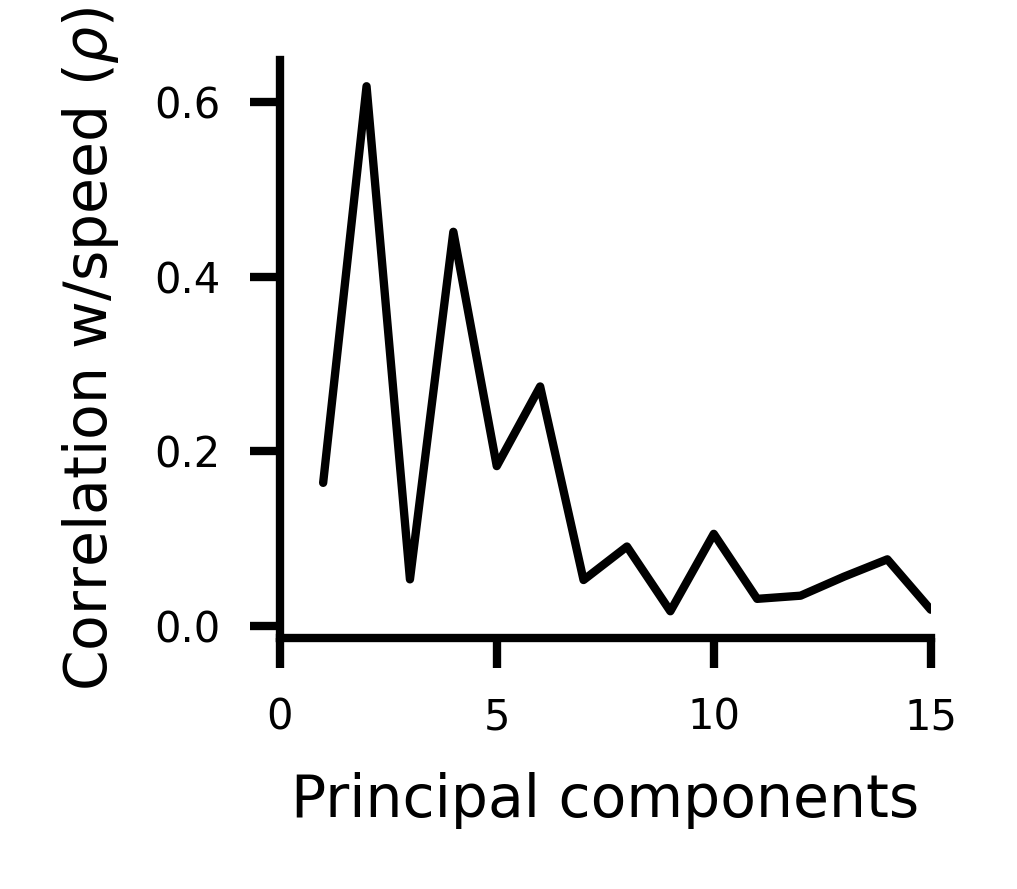

In [21]:
corrs = filtered.corr(method='spearman')['velocity_3d_mm']
fig = figure(1.4, 1.25)
plt.plot(np.arange(1, 16), corrs.iloc[:-1].abs().to_numpy(), color='k')
ax = fig.gca()
ax.set(ylabel='Correlation w/speed ($\\rho$)', xlabel='Principal components', xlim=(0, 15))
sns.despine()
saver(fig, 'pc-corr-vs-speed');

# Females

In [23]:
c = PlotConfig()
saver = save_factory(c.save_path / "female-age-manifold", tight_layout=False)

In [24]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_females_syllable_df.parquet')
df, usage_map = relabel_by_usage(df)
df['age'] = df['age'].map(age_map)

usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)

tms = df.query('onsets').groupby(['age', 'uuid'], sort=False).apply(compute_tm).reset_index()
tm_mtx = tms.pivot_table(values='freq', columns='bigram', index=['age', 'uuid']).fillna(0)

In [25]:
speed = df.groupby(['age', 'uuid'], sort=False)['velocity_3d_mm'].mean()

In [26]:
pca = PCA(n_components=15)
# pcs = pca.fit_transform(np.log(usage_mtx + 1e-6))
pcs = pca.fit_transform((usage_mtx + 1e-6))

In [27]:
pc_df = pd.DataFrame(pcs, index=usage_mtx.index, columns=[f'pc_{x:02d}' for x in range(pcs.shape[1])])

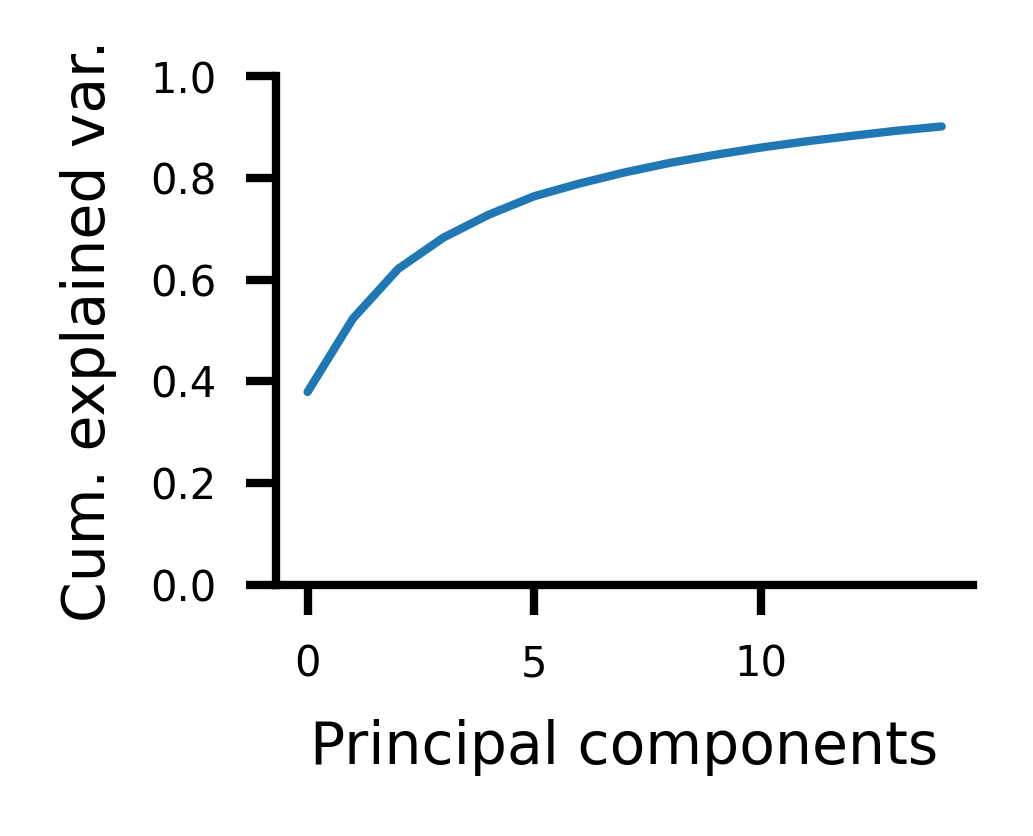

In [28]:
fig = figure(1.5, 1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
ax = fig.gca()
ax.set(xlabel="Principal components", ylabel="Cum. explained var.", ylim=(0, 1))
sns.despine()
saver(fig, 'pca-scree');

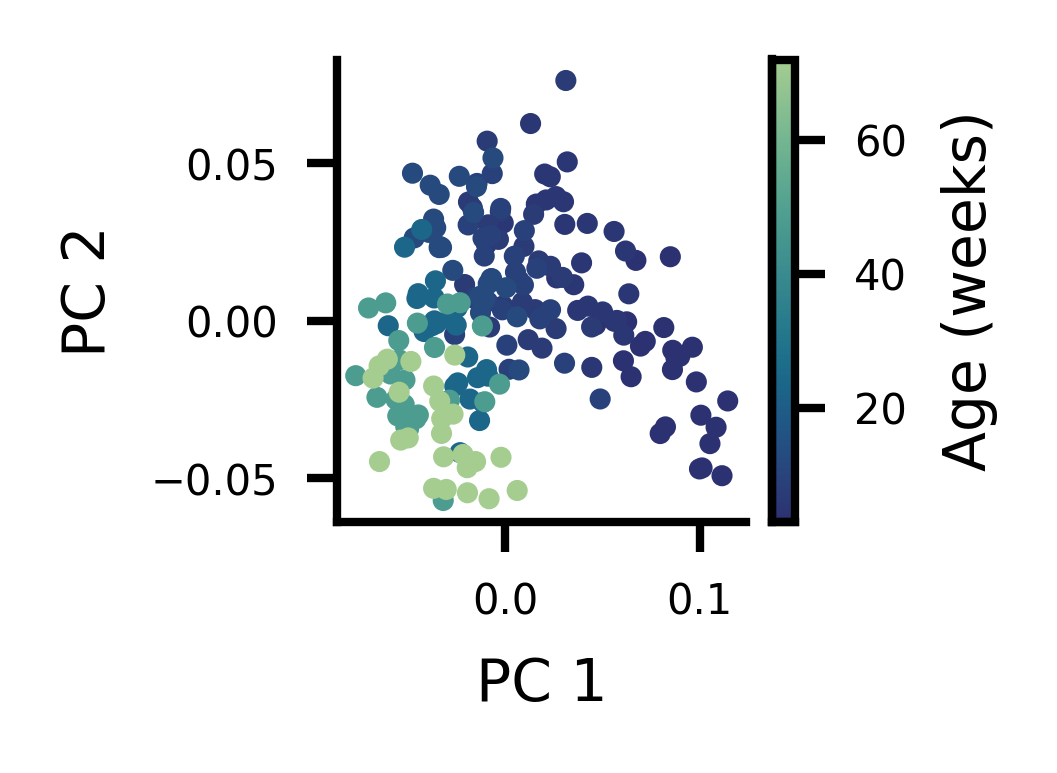

In [29]:
fig = figure(1.1, 1)
ax = fig.gca()
im = ax.scatter(*pcs[:, :2].T, c=usage_mtx.index.get_level_values(0), cmap='crest_r', s=3)
ax.set(xlabel='PC 1', ylabel='PC 2')
fig.colorbar(im, label='Age (weeks)')
sns.despine()
saver(fig, 'pc1-vs-pc2');

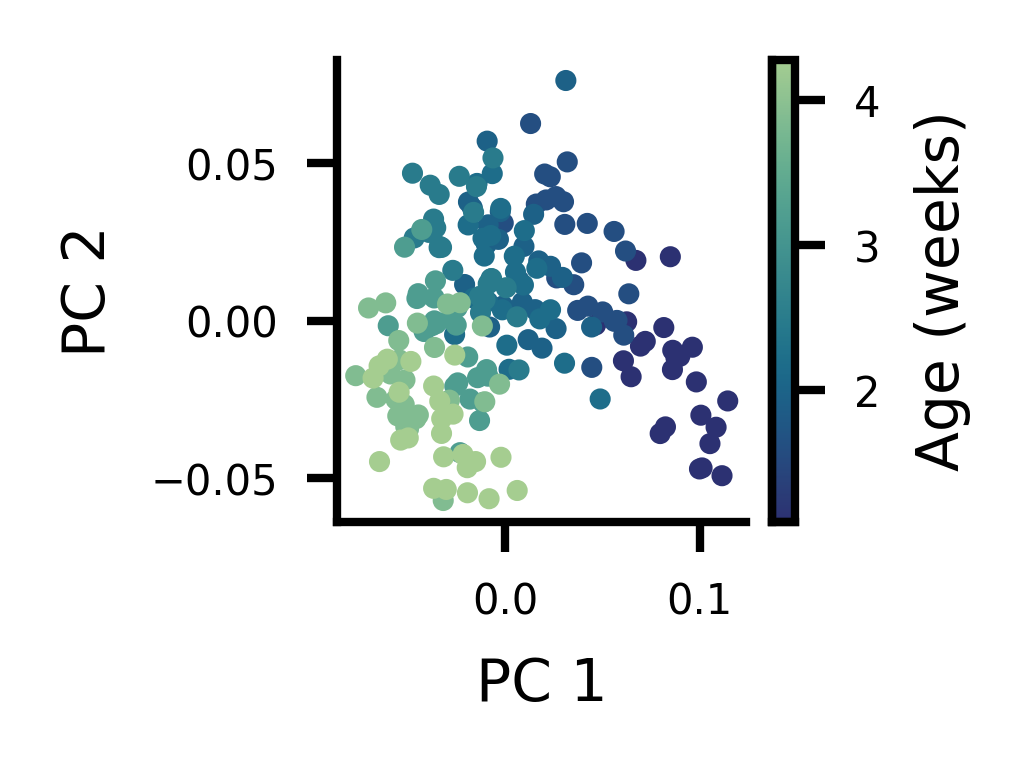

In [30]:
fig = figure(1.1, 1)
ax = fig.gca()
im = ax.scatter(*pcs[:, :2].T, c=np.log(usage_mtx.index.get_level_values(0)), cmap='crest_r', s=3)
ax.set(xlabel='PC 1', ylabel='PC 2')
fig.colorbar(im, label='Age (weeks)')
sns.despine()

In [31]:
combined = pc_df.join(speed)
filtered = combined.where(combined['velocity_3d_mm'] < 5)
filtered['velocity_3d_mm'] *= 30

In [32]:
corrs = filtered.corr(method='spearman')['velocity_3d_mm'].sort_values(ascending=False)
corrs

velocity_3d_mm    1.000000
pc_01             0.370473
pc_02             0.294519
pc_06             0.261286
pc_00             0.068712
pc_05             0.051458
pc_09            -0.014624
pc_12            -0.105497
pc_11            -0.114787
pc_14            -0.119073
pc_13            -0.161770
pc_08            -0.167132
pc_10            -0.240378
pc_03            -0.240921
pc_04            -0.333888
pc_07            -0.378560
Name: velocity_3d_mm, dtype: float64

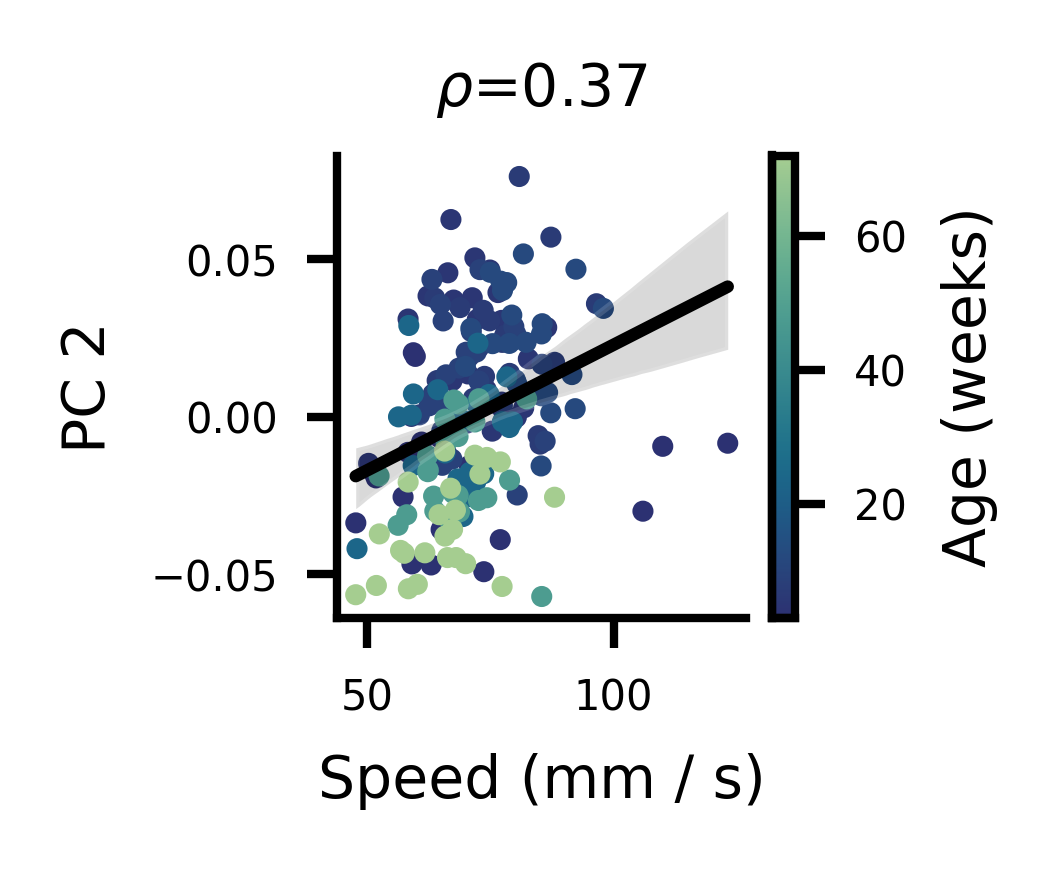

In [33]:
fig = figure(1.1, 1)
plt.scatter(filtered['velocity_3d_mm'], filtered['pc_01'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered, x='velocity_3d_mm', y='pc_01', scatter=False, color='k')
ax.set(xlabel='Speed (mm / s)', ylabel='PC 2')
plt.title(f'$\\rho$={corrs["pc_01"]:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc2-vs-speed');

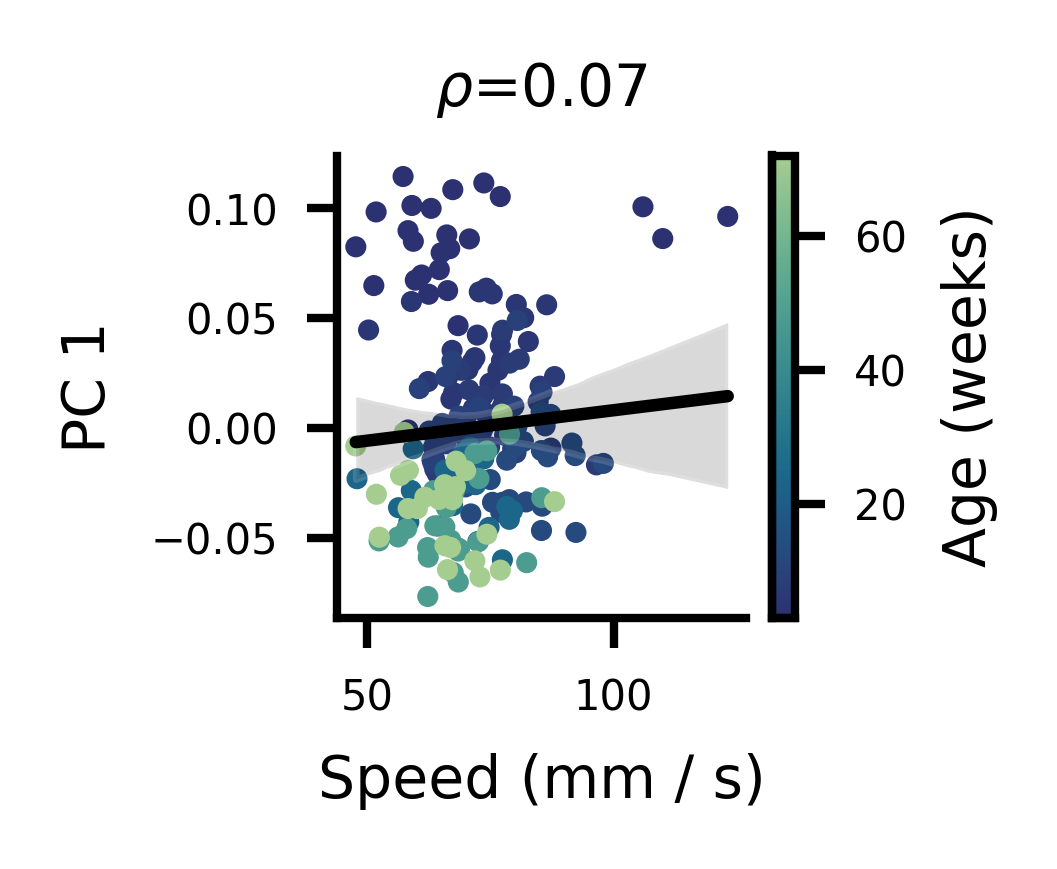

In [34]:
fig = figure(1.1, 1)
plt.scatter(filtered['velocity_3d_mm'], filtered['pc_00'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered, x='velocity_3d_mm', y='pc_00', scatter=False, color='k')
ax.set(xlabel='Speed (mm / s)', ylabel='PC 1')
plt.title(f'$\\rho$={corrs["pc_00"]:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc1-vs-speed');

In [35]:
c = filtered['pc_00'].corr(pd.Series(filtered.index.get_level_values(0), index=filtered.index), method='spearman')

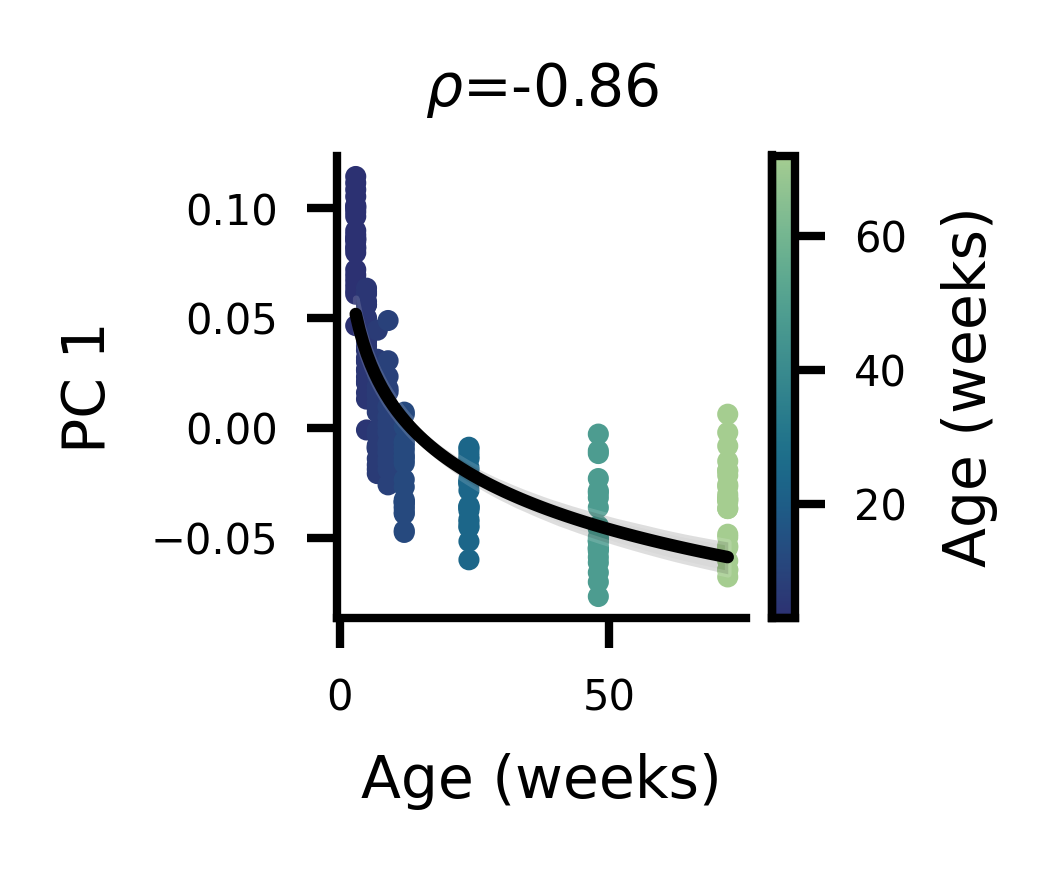

In [36]:
fig = figure(1.1, 1)
plt.scatter(filtered.index.get_level_values(0), filtered['pc_00'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered.reset_index(), x='age', y='pc_00', scatter=False, color='k', logx=True)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
plt.title(f'$\\rho$={c:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc1-vs-age');

In [37]:
age_c = filtered.corrwith(pd.Series(filtered.index.get_level_values(0), index=filtered.index), method='spearman')
age_c

pc_00            -0.856697
pc_01            -0.383899
pc_02             0.081822
pc_03             0.100628
pc_04             0.006705
pc_05            -0.074590
pc_06            -0.056194
pc_07            -0.032459
pc_08            -0.069115
pc_09             0.037267
pc_10            -0.085661
pc_11             0.028731
pc_12             0.050204
pc_13            -0.036812
pc_14            -0.043407
velocity_3d_mm   -0.103497
dtype: float64

In [38]:
age_c.abs().sort_values(ascending=False)

pc_00             0.856697
pc_01             0.383899
velocity_3d_mm    0.103497
pc_03             0.100628
pc_10             0.085661
pc_02             0.081822
pc_05             0.074590
pc_08             0.069115
pc_06             0.056194
pc_12             0.050204
pc_14             0.043407
pc_09             0.037267
pc_13             0.036812
pc_07             0.032459
pc_11             0.028731
pc_04             0.006705
dtype: float64

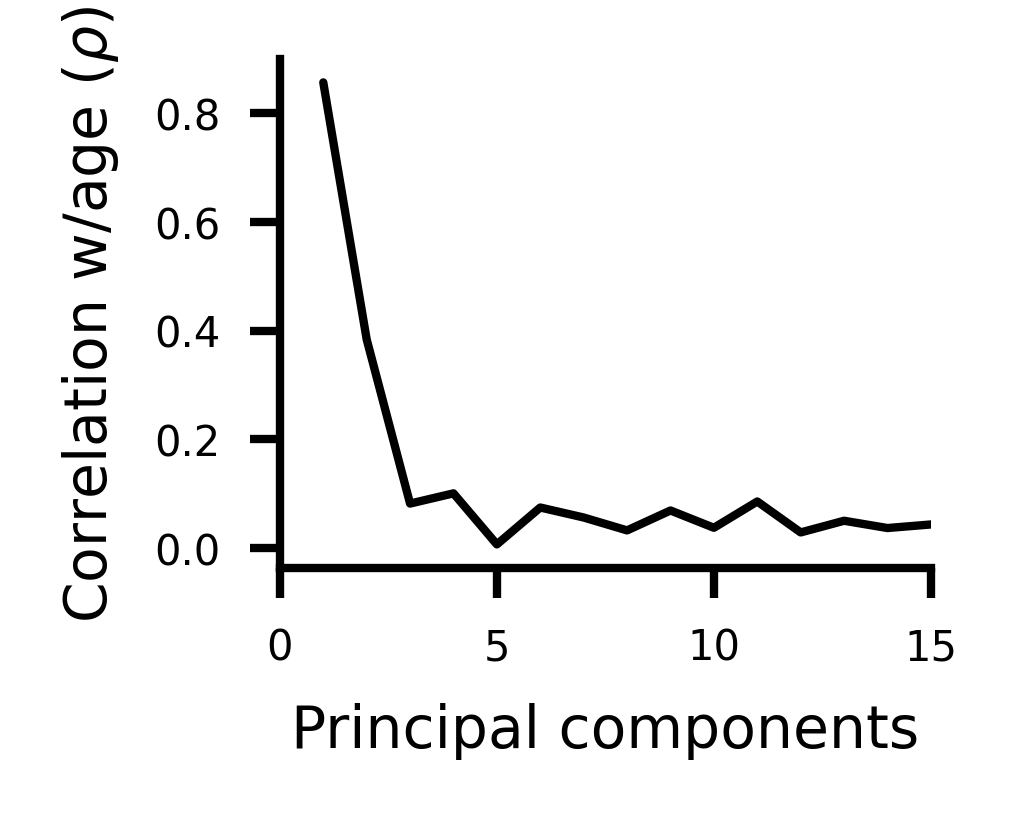

In [39]:
fig = figure(1.4, 1.1)
plt.plot(np.arange(1, 16), age_c.iloc[:-1].abs().to_numpy(), color='k')
ax = fig.gca()
ax.set(ylabel='Correlation w/age ($\\rho$)', xlabel='Principal components', xlim=(0, 15))
sns.despine()
saver(fig, 'pc-corr-vs-age');

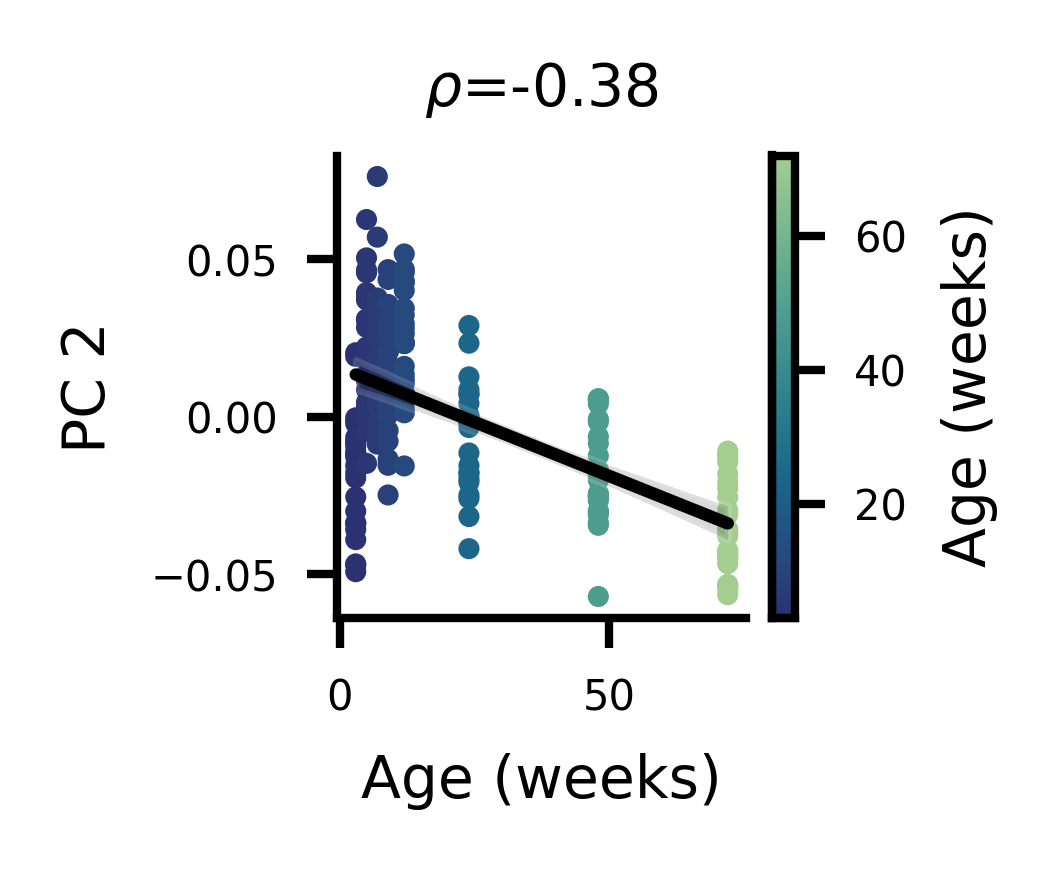

In [40]:
fig = figure(1.1, 1)
plt.scatter(filtered.index.get_level_values(0), filtered['pc_01'], s=3, c=filtered.index.get_level_values(0), cmap='crest_r')
ax = sns.regplot(data=filtered.reset_index(), x='age', y='pc_01', scatter=False, color='k', logx=False)
ax.set(xlabel='Age (weeks)', ylabel='PC 2')
plt.title(f'$\\rho$={age_c["pc_01"]:0.2f}')
plt.colorbar(label='Age (weeks)')
sns.despine()
saver(fig, 'pc2-vs-age');

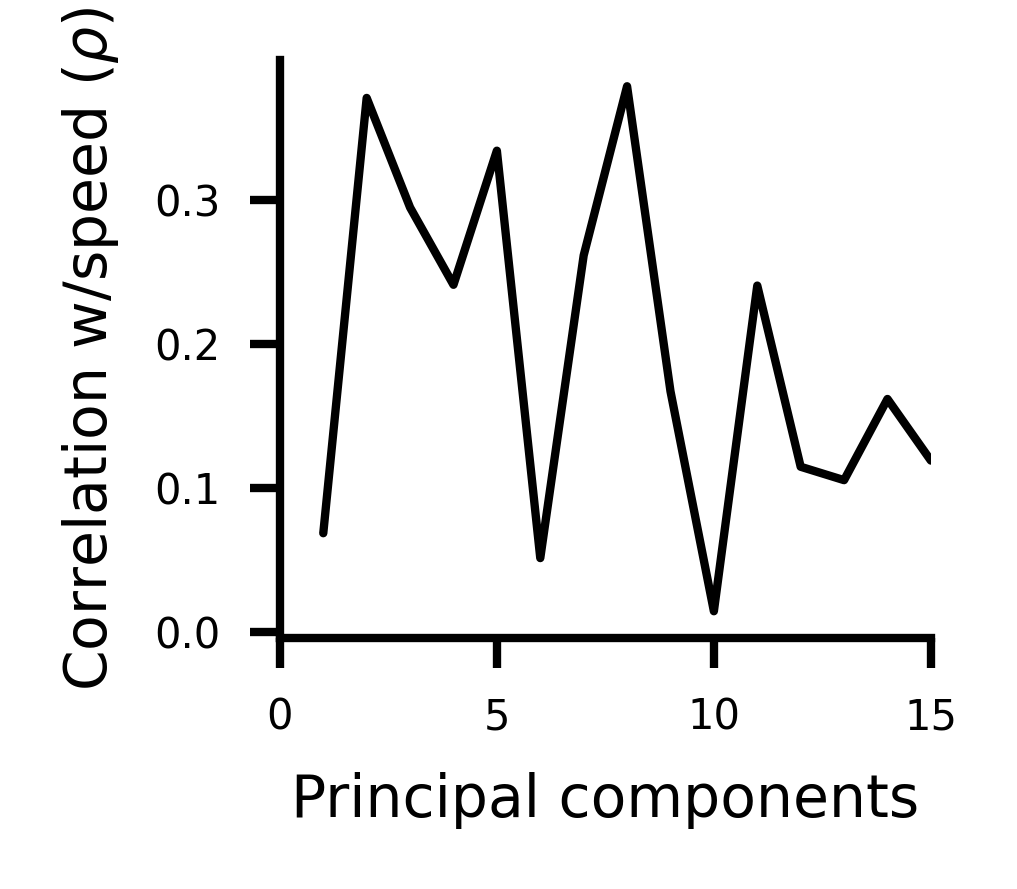

In [41]:
corrs = filtered.corr(method='spearman')['velocity_3d_mm']
fig = figure(1.4, 1.25)
plt.plot(np.arange(1, 16), corrs.iloc[:-1].abs().to_numpy(), color='k')
ax = fig.gca()
ax.set(ylabel='Correlation w/speed ($\\rho$)', xlabel='Principal components', xlim=(0, 15))
sns.despine()
saver(fig, 'pc-corr-vs-speed');